Hello! This notebook is about buildling a pipeline that predicts the price of a plane ticket based on different features.

# Importing data and libraries

In [55]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

In [56]:
flight_data = pd.read_csv('Clean_Dataset.csv')
flight_data.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [57]:
flight_data.shape

(300153, 12)

Because there 300153 rows, I limited the data to ~ 50,000 rows so the training time of the model would not be too long.

In [58]:
#Randomly sampling 50,000 rows to use as our data. random_state is for reproducibility.
#flight_data = flight_data.sample(n = 10000, random_state = 42)

In [59]:
flight_data.describe()

,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


In [60]:
flight_data.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [61]:
flight_data.columns

Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')

In [62]:
flight_data['flight'].nunique()

1561

Since there are so many unique flight values, I decided to drop the feature.

In [63]:
flight_data.drop(['Unnamed: 0', 'flight'], axis = 1, inplace = True)

In [64]:
#Splitting categorical and numerical columns for EDA and for preprocessing
numeric = flight_data.select_dtypes([np.number])
categorical = flight_data.drop(['duration', 'days_left', 'price'], axis = 1)

## EDA

In [65]:
#function to draw boxplots
def draw_box(df, columns):
    for i in columns:
        sns.boxplot(x = df[i])
        plt.show()

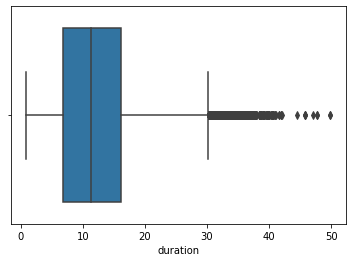

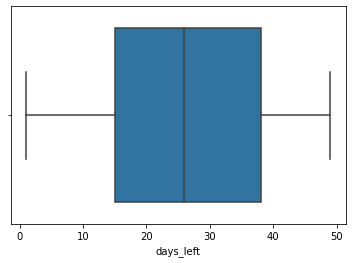

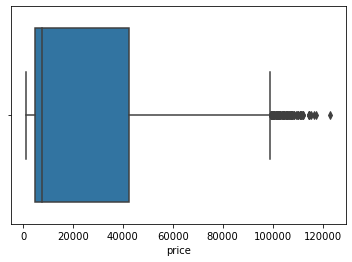

In [66]:
draw_box(flight_data, numeric)

Price and duration have some outliers.

In [67]:
#function to draw histograms for numeric features
def draw_hist(df, columns):
    for i in columns:
        sns.histplot(data = df[i], bins = 40)
        plt.show()

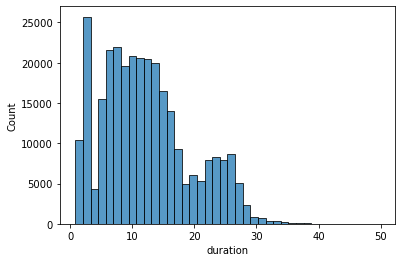

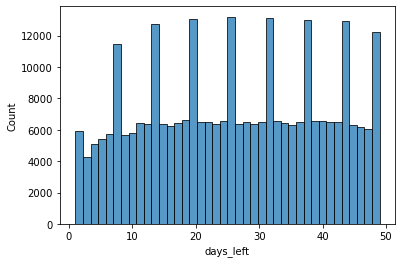

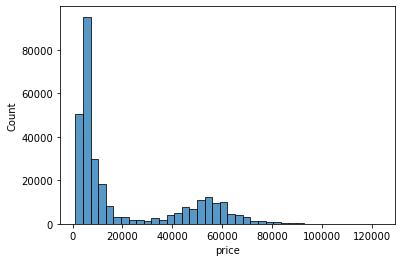

In [68]:
draw_hist(flight_data, numeric)

In [69]:
#function to make countplots of categorical features
def draw_count(df, columns):
    for i in columns:
        sns.countplot(x = df[i])
        plt.show()

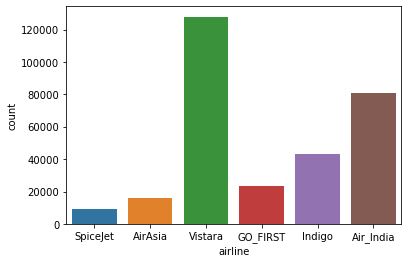

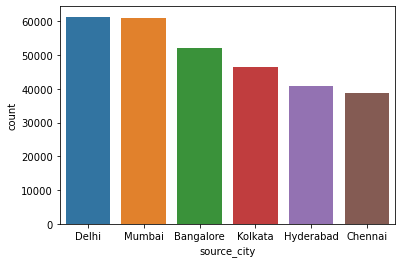

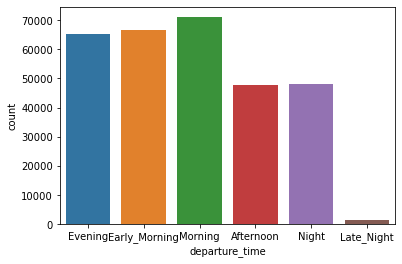

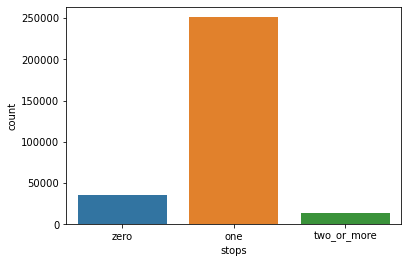

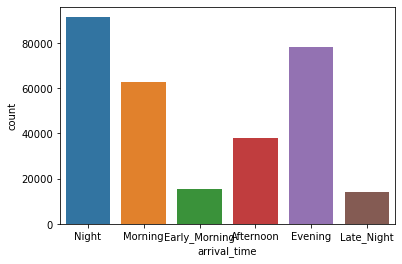

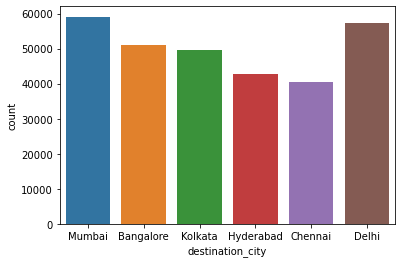

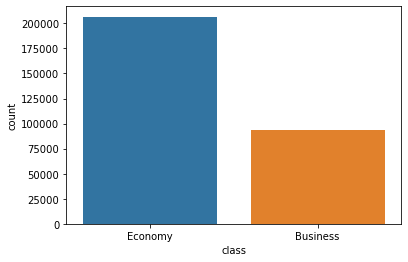

In [70]:
draw_count(flight_data, categorical)

Just by examining the column names, here are some categorical features I wanted to investigate as they related to price

In [71]:
hue_list = ['airline', 'departure_time', 'stops', 'class']

In [72]:
#function that draws violinplots but separates by each category
def draw_violin(df, feature_list):
    for i in feature_list:
        sns.violinplot(x = df['price'], y = df[i], bins = 20)
        plt.show()

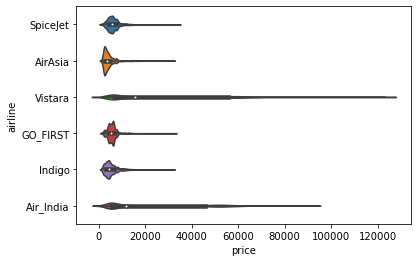

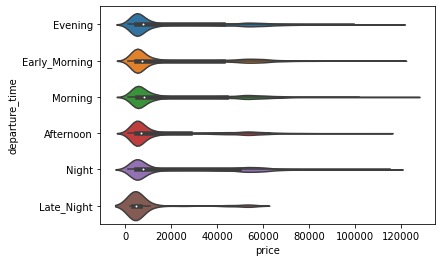

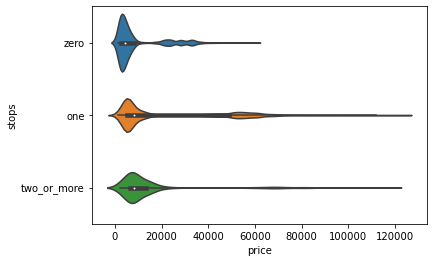

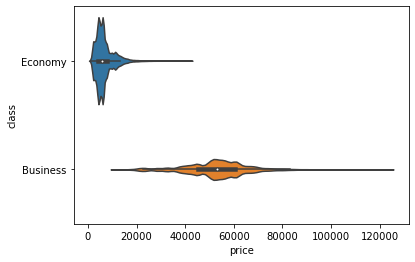

In [73]:
draw_violin(flight_data, hue_list)

Notes about violin plot:

1. Airline: Vistara and AirIndia have a higher median price than the rest 
2. Stops: Price seems to increase as the number of stops increase
3. Class: Price increases when someone is in business class compared to economy

airline and departure_time have a lot of unique categories, so it is hard to see the differences in the distributions of those categories. We can try looking at the median price grouped by departure_time and airline separately. 

In [74]:
flight_data.groupby('airline').median()

,duration,days_left,price
airline,,,
AirAsia,9.33,28.0,3276.0
Air_India,15.00,26.0,11520.0
GO_FIRST,8.83,27.0,5336.0
Indigo,6.00,27.0,4453.0
SpiceJet,12.00,23.0,5654.0
Vistara,12.50,26.0,15543.0


In [75]:
flight_data.groupby('departure_time').median()

,duration,days_left,price
departure_time,,,
Afternoon,8.170,26.0,6663.0
Early_Morning,11.580,26.0,7212.0
Evening,14.500,26.0,7425.0
Late_Night,6.625,29.0,4499.0
Morning,10.000,26.0,8112.0
Night,13.420,26.0,7813.0


There are also some numerical features I wanted to explore

In [76]:
numeric_scatter_list = ['duration', 'days_left']

In [77]:
#function that draws scatterplots (feature vs price)
def draw_scatter(df, scatter_list):
    for i in scatter_list:
        sns.scatterplot(x = df[i], y = df['price'])
        plt.show()

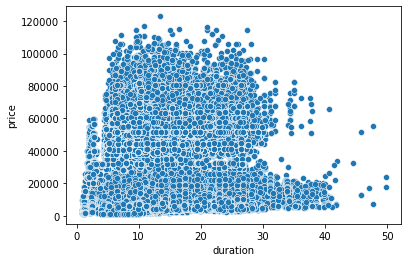

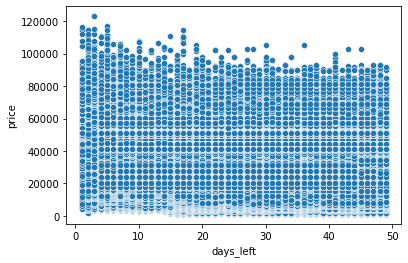

In [78]:
draw_scatter(flight_data, numeric_scatter_list)

It looks like we can't make out much from the graphs

Correlations

In [79]:
#function that creates correlation matrix with numerical features
def corr_matrix(df):
    fig, ax = plt.subplots(figsize = (10, 10))
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

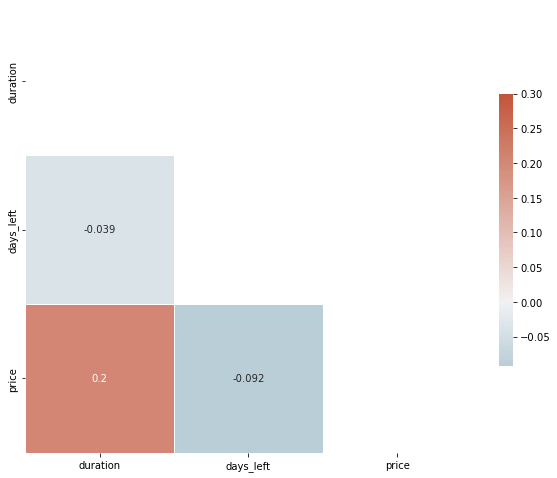

In [80]:
corr_matrix(flight_data)

# Creating Pipeline

## Preprocessing:  
Since there are no null values, we just have to perform the following transformations to our data:  
  1. Scale numeric data
  2. Ordinal Encode catergorical variables (stops, class)
  3. One hot the rest of the categorical data

In [81]:
#Separating features and target
X = flight_data.drop('price', axis = 1)
y = flight_data['price']

In [82]:
#Creating OneHotEncoder and StandardScaler objects
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)
scaler = StandardScaler()

In [83]:
#Ordinal encoder categories
stops_cat = [['zero', 'one', 'two_or_more']]
class_cat = [['Economy', 'Business']]

In [84]:
#dropping price (the target) from our numeric columns
numeric.drop('price', axis = 1, inplace = True)

In [85]:
ohe_columns = categorical.drop(['stops', 'class'], axis = 1).columns

In [86]:
#Creating a column transformer to preprocess data
column_trans = make_column_transformer(
    (OrdinalEncoder(categories = stops_cat), ['stops']),
    (OrdinalEncoder(categories = class_cat), ['class']),
    (ohe, ohe_columns), 
    (scaler, list(numeric.columns)),
     remainder = 'passthrough')
column_trans.fit_transform(X)

array([[ 0.        ,  0.        ,  0.        , ...,  1.        ,
        -1.39753079, -1.84387477],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
        -1.3752838 , -1.84387477],
       [ 0.        ,  0.        ,  1.        , ...,  1.        ,
        -1.39753079, -1.84387477],
       ...,
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
         0.22371837,  1.69569214],
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
        -0.30881888,  1.69569214],
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
        -0.29769538,  1.69569214]])

# Testing pipeline with different models  
1. Create pipeline with different models
2. Look at the cross validation score to see which models are worth tuning

In [87]:
linreg = LinearRegression()
pipe_lin = make_pipeline(column_trans, linreg)

In [88]:
#linear regression
cross_val_score(pipe_lin, X, y, cv = 5, scoring='neg_root_mean_squared_error').mean()

-7136.131624036697

In [89]:
lassoreg = Lasso()
pipe_lasso = make_pipeline(column_trans, lassoreg)

In [90]:
#lasso regression
cross_val_score(pipe_lasso, X, y, cv = 5, scoring='neg_root_mean_squared_error').mean()

-7128.6284080374435

In [91]:
treereg = DecisionTreeRegressor()
pipe_tree = make_pipeline(column_trans, treereg)

In [92]:
#decision tree regression
cross_val_score(pipe_tree, X, y, cv = 5, scoring='neg_root_mean_squared_error').mean()

-6352.5877220330085

In [93]:
xgbreg = xgb.XGBRegressor()
pipe_xgb = make_pipeline(column_trans, xgbreg)

In [94]:
#xgboost regression
cross_val_score(pipe_xgb, X, y, cv = 5, scoring='neg_root_mean_squared_error').mean()

-5627.2429390701045

xgboost, decision trees, and lasso will be tuned because they were the top 3 models. Linear regression doesn't have hyperparameters to be tuned anyway.

In [123]:
#Create a function that does the gridsearch and returns the best score and the best parameters 
def tune_model(pipe, pipe_params, X, y):
    search = RandomizedSearchCV(pipe, pipe_params, scoring = 'neg_root_mean_squared_error', n_iter = 50, n_jobs = -1)
    search.fit(X,y)
    return search.best_score_, search.best_estimator_

In [96]:
#Lasso gridsearch
lasso_params = {
    'lasso__alpha' : [0.25, 0.5, 0.75, 0.9, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100]
}
lasso_score, lasso_best_params = tune_model(pipe_lasso, lasso_params, X, y)

c:\Users\kevoi\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 15 is smaller than n_iter=50. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [97]:
lasso_score

-6736.338072719086

In [98]:
lasso_best_params

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['zero',
                                                                              'one',
                                                                              'two_or_more']]),
                                                  ['stops']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['Economy',
                                                                              'Business']]),
                                                  ['class']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                 

In [99]:
#Decision Tree gridsearch
#Credit for parameters: https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/
tree_params = {
    "decisiontreeregressor__splitter" : ['best', 'random'],
    "decisiontreeregressor__max_depth" : [None],
    "decisiontreeregressor__min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
    "decisiontreeregressor__min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
    "decisiontreeregressor__max_features":["auto","log2","sqrt",None],
    "decisiontreeregressor__max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] ,
    "decisiontreeregressor__random_state" : [42]
}
tree_score, tree_best_params = tune_model(pipe_tree, tree_params, X, y)

In [100]:
tree_score

-6314.436481516546

In [101]:
tree_best_params

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['zero',
                                                                              'one',
                                                                              'two_or_more']]),
                                                  ['stops']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['Economy',
                                                                              'Business']]),
                                                  ['class']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                 

In [124]:
#xgboost gridsearch
#credit for parameters: https://github.com/krishnaik06/Hyperparameter-Optimization/blob/master/Hyperparameter%20Optimization%20For%20Xgboost.ipynb
xgb_params = {
    "xgbregressor__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
    "xgbregressor__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12],
    "xgbregressor__min_child_weight" : [ 1, 3, 5, 7 ],
    "xgbregressor__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "xgbregressor__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7, 1]   
}
xgb_score, xgb_best_params = tune_model(pipe_xgb, xgb_params, X, y)

In [125]:
xgb_score

-4960.239212115941

In [126]:
xgb_best_params

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['zero',
                                                                              'one',
                                                                              'two_or_more']]),
                                                  ['stops']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['Economy',
                                                                              'Business']]),
                                                  ['class']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                 

xgboost was still the best performing model, so we will make our final model with the best parameters.

# Creating final model and evaluating it

In [127]:
final_pipe = xgb_best_params

In [128]:
#using the model to predict prices
y_pred = cross_val_predict(final_pipe, X, y, cv=10)

In [129]:
#function to get the metrics to measure final model's performance
def print_metrics(pipe, X, y, y_pred):
    print('Negative root mean squared error: ', 
        round(cross_val_score (pipe, X, y, cv = 5, scoring = 'neg_root_mean_squared_error').mean(), 3))
    print('R squared: ', round(r2_score(y, y_pred), 4))

In [130]:
print_metrics(final_pipe, X, y, y_pred)

Negative root mean squared error:  -4960.239
R squared:  0.943


In [131]:
#function that displays actual y vs predicted y
def visualize_predictions(pipe, X, y, y_pred):
    fig, ax = plt.subplots()
    ax.scatter(y, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

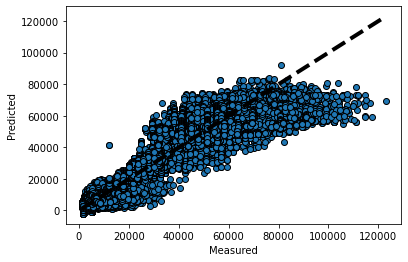

In [132]:
visualize_predictions(final_pipe, X, y, y_pred)

As seen in the graph, when the measured price is around 80,000 and above, our model underestimates the actual price. However, we were still able to 